# Climate Analysis and Exploration

In [1]:
# %matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import date, timedelta

In [4]:
from functools import reduce

## Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [6]:
engine = create_engine('sqlite:///hawaii.sqlite')

In [7]:
# reflect an existing database into ORM classes
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurements', 'stations']

In [8]:
# Save references to each table
Measurement = Base.classes.measurements
Station = Base.classes.stations

In [9]:
# Create session (link) from Python to the DB
session = Session(engine)

## Precipitation Analysis

###### Retrieve the last 12 months of precipitation data and plot the results

In [10]:
# the last date in the dataframe
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [11]:
# Last date year ago
last_date_YA = dt.date(2017, 8, 23) - dt.timedelta(days=365)
last_date_YA

datetime.date(2016, 8, 23)

In [12]:
# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, func.avg(Measurement.prcp)).\
                    filter(Measurement.date >= last_date_YA).\
                    group_by(Measurement.date).all()
# precipitation

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort Dataframe by Date
precipitation_df = pd.DataFrame(precipitation, columns=['Date', 'Prcp'])
precipitation_df.set_index('Date', inplace=True)
precipitation_df.head()

,Prcp
Date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000


<function matplotlib.pyplot.show>

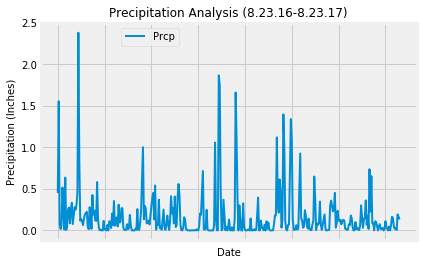

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(kind='line', linewidth=2)

plt.legend(bbox_to_anchor=(0.2,1), fontsize='10')
plt.title('Precipitation Analysis (8.23.16-8.23.17)', size=12)
plt.ylabel('Precipitation (Inches)', size=10)
plt.xlabel('Date', size=10)

plt.savefig('Output/Precipitation Analysis.png')
plt.show

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Prcp
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


## Station Analysis

In [16]:
# How many stations are available in this dataset?
station_count = session.query(Station.station).count()
station_count

9

In [17]:
# What are the most active stations?
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.tobs)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.tobs).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

most_active_station = active_stations[0][0]

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
             filter(Measurement.station == most_active_station).all()


[(54, 85, 71.66378066378067)]

In [19]:
# Choose the station with the highest number of temperature observations.
most_active_station

'USC00519281'

In [20]:
# Query the last 12 months of temperature observation data for this station
tobs_active = session.query(Measurement.date, Measurement.tobs).\
                filter(Measurement.station == most_active_station).\
                filter(Measurement.date >= last_date_YA).all()
        

tobs_active_df = pd.DataFrame(tobs_active)
tobs_active_df .set_index('date', inplace=True)
tobs_active_df .head()

,tobs
date,
2016-08-23,77
2016-08-24,77
2016-08-25,80
2016-08-26,80
2016-08-27,75


<function matplotlib.pyplot.show>

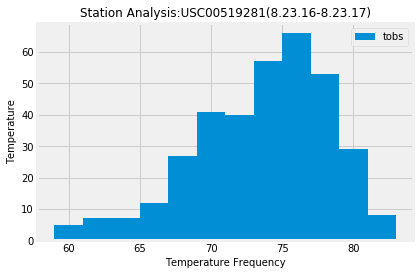

In [21]:
# Plot the results as a histogram
tobs_active_df.plot.hist(bins=12)


plt.title("Station Analysis:" + most_active_station+ '(8.23.16-8.23.17)', fontsize=12)
plt.xlabel("Temperature Frequency", fontsize=10)
plt.ylabel("Temperature", fontsize=10)
plt.savefig("Output/Station Analysis.png")
plt.show


## Temperature Analysis

###### Planning Trip from date 7.8.2018-7.23.2018

In [22]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_tobs = calc_temps('2017-07-08', '2017-07-23')
trip_tobs

[(69, 78.28571428571429, 83)]

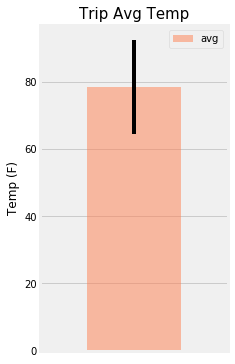

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

avg_temp_df = pd.DataFrame(trip_tobs, columns=['min', 'avg', 'max'])

avg_temp_df = avg_temp_df['avg']

avg_temp_df.plot(kind='bar', yerr=(trip_tobs[0][2]-trip_tobs[0][0]), alpha=0.5, color='coral',figsize=(3,6))

plt.title('Trip Avg Temp', fontsize=15)
plt.ylabel('Temp (F)')
plt.xticks([])
plt.legend()

plt.savefig('Output/Temperature Analysis.png')
plt.show()


In [25]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount 
def calc_prcp(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(Measurement.station,Measurement.prcp, Station.name, Station.latitude,Station.longitude, Station.elevation).\
           filter(Measurement.station==Station.station).\
           filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
           group_by(Measurement.station).\
           order_by((Measurement.prcp).desc()).all()

trip_prcp = calc_prcp('2017-07-08', '2017-07-23')
trip_prcp


[('USC00516128',
  0.8,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  0.2,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999995,
  32.9),
 ('USC00514830',
  0.07,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00513117', 0.06, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00517948', 0.0, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00519397', 0.0, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519523',
  0.0,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5)]

## Daily Normals Analysis

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62, 69.06, 77)]

###### Calculate the daily normals for my trip (7.8 - 7.23)

In [27]:
# push each tuple of calculations into a list called `normals`
trip_dates = []
normals = []

# Set the start and end date of the trip
start_date = dt.date(2018, 7, 8)
end_date = dt.date(2018, 7, 23)

# Use the start and end date to create a range of dates
delta = end_date - start_date
for i in range(delta.days + 1):
    trip_dates.append(start_date + timedelta(i))

# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

for trip_date in trip_dates:  
    results = daily_normals(trip_date.strftime('%m-%d'))
    normals.append(results)

normals = reduce(lambda x,y: x+y, normals)
normals

[(69, 75.6, 81),
 (68, 76.09433962264151, 83),
 (68, 75.50943396226415, 82),
 (70, 75.47058823529412, 81),
 (67, 75.76923076923077, 82),
 (69, 76.11764705882354, 81),
 (67, 76.36538461538461, 82),
 (68, 76.21818181818182, 82),
 (70, 76.28571428571429, 83),
 (70, 76.3921568627451, 83),
 (72, 76.62745098039215, 83),
 (68, 75.83018867924528, 83),
 (69, 75.32692307692308, 82),
 (69, 76.9795918367347, 83),
 (69, 75.75510204081633, 81),
 (70, 75.94, 82)]

In [28]:
# Load the previous query results into a Pandas DataFrame and \
# add the `trip_dates` range as the `date` index

normals_df = pd.DataFrame(normals, columns = ['tmin', 'tavg', 'tmax'])
normals_df['Date'] = trip_dates
normals_df = normals_df.set_index('Date')

normals_df

,tmin,tavg,tmax
Date,,,
2018-07-08,69,75.600000,81
2018-07-09,68,76.094340,83
2018-07-10,68,75.509434,82
2018-07-11,70,75.470588,81
2018-07-12,67,75.769231,82
2018-07-13,69,76.117647,81
2018-07-14,67,76.365385,82
2018-07-15,68,76.218182,82
2018-07-16,70,76.285714,83


<function matplotlib.pyplot.show>

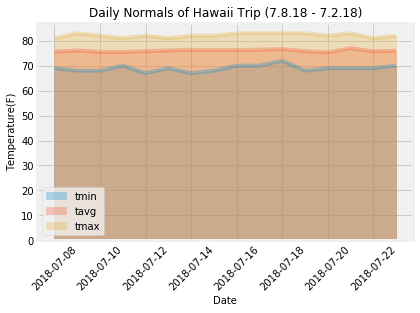

In [29]:
# Plot the daily normals as an area plot with `stacked=False`

normals_df.plot(kind='area',stacked=False,alpha=0.3)

plt.xlabel("Date",fontsize=10)
plt.ylabel("Temperature(F)",fontsize=10)
plt.title("Daily Normals of Hawaii Trip (7.8.18 - 7.2.18)", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

plt.savefig("Output/Daily Normals Analysis.png")
plt.show